## Imports

In [1]:
!pip install evaluate

In [2]:
!pip install accelerate -U

  Using cached accelerate-0.25.0-py3-none-any.whl (265 kB)


In [3]:
!pip install datasets
!pip install -q transformers

In [4]:
!pip install git+https://github.com/k4black/codebleu.git

  Cloning https://github.com/k4black/codebleu.git to /tmp/pip-req-build-v2a5jjme
  Running command git clone --filter=blob:none --quiet https://github.com/k4black/codebleu.git /tmp/pip-req-build-v2a5jjme
  Resolved https://github.com/k4black/codebleu.git to commit 523408a2f79ac2bcb8ede68b9193546d3bb2c771
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached tree_sitter-0.20.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (488 kB)
  Created wheel for codebleu: filename=codebleu-0.4.0-cp310-cp310-linux_x86_64.whl size=1120266 sha256=8f0e60f1d66928a82847a3b70cf7d1a9623e06e05aa92e91cb1ddbe75c070973
  Stored in directory: /tmp/pip-ephem-wheel-cache-8b2w7mcp/wheels/a9/a1/49/7239f72f9b8a11eeacd2924273f78a59b95e0c3ad588020b6e
Successfully built codebleu


In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import os

import torch
from datasets import load_dataset
from datasets import Dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, TrainingArguments, Trainer
from transformers import RobertaTokenizer, T5ForConditionalGeneration, T5Config

from codebleu import calc_codebleu

## Dataset

In [10]:
df = pd.read_csv("django.csv", sep="\t")
df.fillna('', inplace=True)

### EDA

In [11]:
df.sample(3)

,Name,Args,Body,Context,File name
27689,as_mysql,"self, compiler, connection","lhs, params, key_transforms = self.pre...",KeyTransform;,django/db/models/fields/json.py
18916,test_difference,self,"""Testing difference().""\n for i...",OGRGeomTest;,tests/gis_tests/gdal_tests/test_geom.py
8334,test_render_value,self,self.check_html(\n self.wid...,TextInputTest;,tests/forms_tests/widget_tests/test_textinput.py


In [12]:
df.describe()

,Name,Args,Body,Context,File name
count,28178,28178,28178,28178,28178
unique,18827,2774,26733,4847,1595
top,__init__,self,return self.name\n,,tests/admin_views/tests.py
freq,894,19426,137,1658,474


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28178 entries, 0 to 28177
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Name       28178 non-null  object
 1   Args       28178 non-null  object
 2   Body       28178 non-null  object
 3   Context    28178 non-null  object
 4   File name  28178 non-null  object
dtypes: object(5)
memory usage: 1.1+ MB


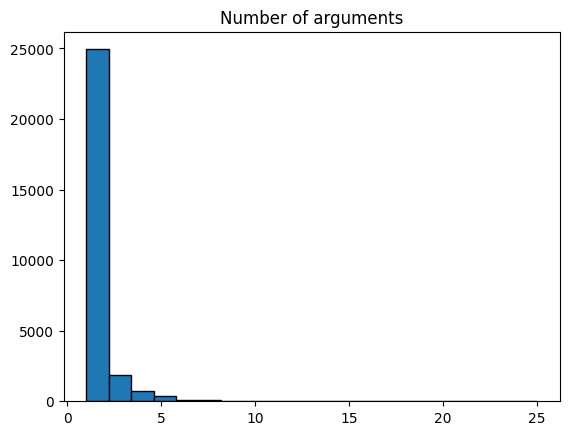

In [14]:
plt.hist(df['Args'].apply(lambda a: a.count(',') + 1), bins=20, edgecolor='black')
plt.title('Number of arguments')
plt.show()

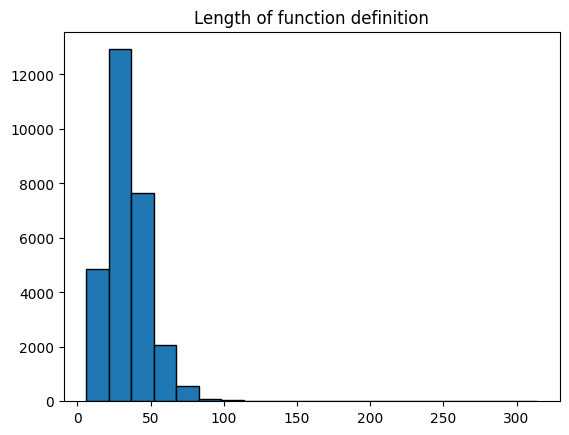

In [15]:
plt.hist([len(f"def {row['Name']}({row['Args']})") for _, row in df.iterrows()], bins=20, edgecolor='black')
plt.title('Length of function definition')
plt.show()

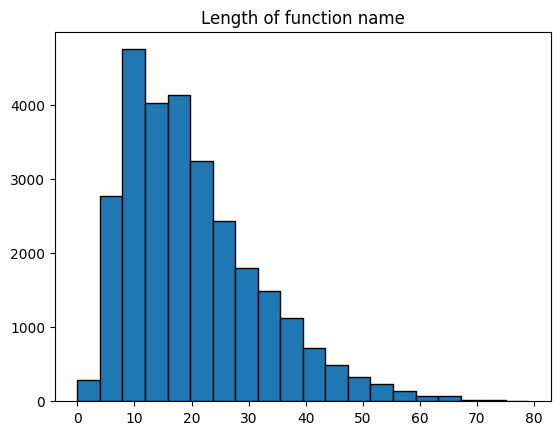

In [16]:
plt.hist([len(row['Name']) for _, row in df.iterrows()], bins=20, edgecolor='black')
plt.title('Length of function name')
plt.show()

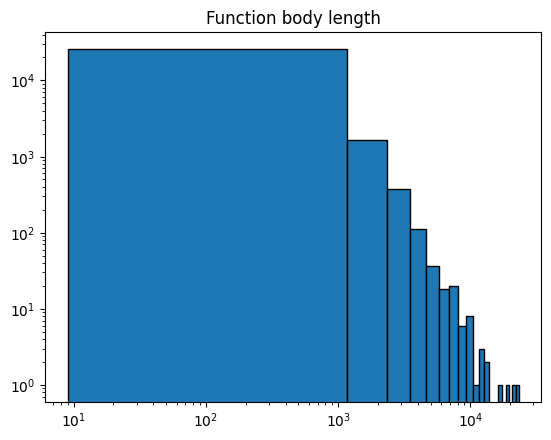

In [17]:
plt.hist(df['Body'].apply(len), bins=20, edgecolor='black')
plt.title('Function body length')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [18]:
train_df, test_df = train_test_split(df, test_size=0.2)

### Datasets:

In [19]:
tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')
model = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-base')

tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/703k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/294k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

In [ ]:
def load_tokenize_data(args, df):
    tokenizer = AutoTokenizer.from_pretrained(args['load'])
    datasets = Dataset.from_pandas(df)


    def preprocess_function(examples):
        source = examples["Body"]
        target = examples["Name"]

        model_inputs = tokenizer(source, max_length=args['max_source_len'], padding="max_length", truncation=True)
        labels = tokenizer(target, max_length=args['max_target_len'], padding="max_length", truncation=True)

        model_inputs["labels"] = labels["input_ids"].copy()
        model_inputs["labels"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in model_inputs["labels"]
        ]
        return model_inputs

    train_data = datasets.map(
        preprocess_function,
        batched=True,
        remove_columns=datasets.column_names,
        num_proc=64,
        load_from_cache_file=False,
    )
    print(f'  ==> Loaded {len(train_data)} samples')
    return train_data

In [ ]:
args = {
    'data_num': -1,
    'max_source_len': 320,
    'max_target_len': 128,
    'cache_data': 'cache_data/summarize_python',
    'load': 'Salesforce/codet5p-220m',
    'epochs': 2,
    'lr': 5e-5,
    'lr_warmup_steps': 200,
    'batch_size_per_replica': 8,
    'grad_acc_steps': 4,
    'local_rank': -1,
    'deepspeed': None,
    'fp16': False,
    'save_dir': 'saved_models/summarize_python',
    'log_freq': 10,
    'save_freq': 500,
}

train_data = load_tokenize_data(args, train_df)

In [ ]:
def run_training(args, model, train_data):
    print(f"Starting main loop")

    training_args = TrainingArguments(
        report_to='tensorboard',
        output_dir=args['save_dir'],
        overwrite_output_dir=False,

        do_train=True,
        save_strategy='epoch',

        num_train_epochs=args['epochs'],
        per_device_train_batch_size=args['batch_size_per_replica'],
        gradient_accumulation_steps=args['grad_acc_steps'],

        learning_rate=args['lr'],
        weight_decay=0.05,
        warmup_steps=args['lr_warmup_steps'],

        logging_dir=args['save_dir'],
        logging_first_step=True,
        logging_steps=args['log_freq'],
        save_total_limit=1,

        dataloader_drop_last=True,
        dataloader_num_workers=4,

        local_rank=args['local_rank'],
        deepspeed=args['deepspeed'],
        fp16=args['fp16'],
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
    )

    trainer.train()
    return trainer.model

In [ ]:
model_after_ft = run_training(args, model, train_data)
torch.save(model_after_ft.state_dict(), 'ft_model.pt')

In [ ]:
model_after_ft.save_pretrained('model')

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('model')

## Comparison

CODEBLEU metric

Unofficial implementation https://huggingface.co/spaces/k4black/codebleu

The source code https://github.com/k4black/codebleu

Origin implementation https://github.com/microsoft/CodeXGLUE/blob/main/Code-Code/code-to-code-trans/CodeBLEU.MD

Paper https://arxiv.org/abs/2009.10297

It can't load metric from evaluate, so a package from github was used

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
model_after_ft = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-base')
model_after_ft.load_state_dict(torch.load("/content/drive/MyDrive/jb-test-checkpoints/ft_model.pt"))
# For some reason, google collab couldn't download the checkpoint, so I had to add it via Google drive.
# But it's the same checkpoint as in the repository.
# To run, the following line can be used:
# model_after_ft.load_state_dict(torch.load("ft_model.pt"))
model_after_ft.eval()

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32100, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32100, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [9]:
model_before_ft = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-base')
model_before_ft.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32100, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32100, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [20]:
test_df.sample(2)[['Name', 'Body']]

,Name,Body
10605,test_refresh_clears_one_to_one_field,article = Article.objects.create(\n ...
8808,test_sql_flush,"msg = ""subclasses of BaseDatabaseOpera..."


In [21]:
# example

text = 'skips = super().django_test_skips skips.update( { "Oracle doesn\'t support spatial operators in constraints.": { "gis_tests.gis_migrations.test_operations.OperationTests." "test_add_check_constraint", }, } ) return skips'
reference = 'def ' + 'django_test_skips'
input_ids = tokenizer(text, return_tensors="pt").input_ids

generated_ids = model_before_ft.generate(input_ids, max_length=8)
prediction = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(prediction)
bleu = calc_codebleu([reference], [prediction], lang="python")
print(bleu)


 def django_test
{'codebleu': 0.5798598256517086, 'ngram_match_score': 0.1495348781221221, 'weighted_ngram_match_score': 0.1699044244847123, 'syntax_match_score': 1.0, 'dataflow_match_score': 0}


In [23]:
from tqdm import tqdm

In [27]:
metrics = []
metrics_ft = []

for i, row in tqdm(test_df.sample(500).iterrows()):
    text = row['Body']
    reference = 'def ' + row['Name']
    input_ids = tokenizer(text, return_tensors="pt").input_ids

    generated_ids = model_before_ft.generate(input_ids, max_length=8)
    prediction = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    bleu = calc_codebleu([reference], [prediction], lang="python")

    generated_ids_ft = model_after_ft.generate(input_ids, max_length=8)
    prediction_ft = tokenizer.decode(generated_ids_ft[0], skip_special_tokens=True)
    bleu_ft = calc_codebleu([reference], [prediction_ft], lang="python")

    metrics.append(bleu)
    metrics_ft.append(bleu_ft)

0it [00:00, ?it/s]WARNING:root:WARNING: There is no reference data-flows extracted from the whole corpus, and the data-flow match score degenerates to 0. Please consider ignoring this score.
1it [00:01,  1.44s/it]WARNING:root:WARNING: There is no reference data-flows extracted from the whole corpus, and the data-flow match score degenerates to 0. Please consider ignoring this score.
2it [00:02,  1.33s/it]WARNING:root:WARNING: There is no reference data-flows extracted from the whole corpus, and the data-flow match score degenerates to 0. Please consider ignoring this score.
3it [00:04,  1.47s/it]WARNING:root:WARNING: There is no reference data-flows extracted from the whole corpus, and the data-flow match score degenerates to 0. Please consider ignoring this score.
4it [00:06,  1.70s/it]WARNING:root:WARNING: There is no reference data-flows extracted from the whole corpus, and the data-flow match score degenerates to 0. Please consider ignoring this score.
5it [00:11,  2.94s/it]WARNING

In [28]:
def mean_std_metrics(metrics_list):
    codebleu_values = np.array([metric['codebleu'] for metric in metrics_list])
    ngram_match_score_values = np.array([metric['ngram_match_score'] for metric in metrics_list])
    weighted_ngram_match_score_values = np.array([metric['weighted_ngram_match_score'] for metric in metrics_list])
    syntax_match_score_values = np.array([metric['syntax_match_score'] for metric in metrics_list])

    print(f"codebleu: {codebleu_values.mean():.3f} +- {codebleu_values.std():.3f}")
    print(f"ngram_match_score:{ngram_match_score_values.mean():.3f} +- {ngram_match_score_values.std():.3f}")
    print(f"weighted_ngram_match_score: {weighted_ngram_match_score_values.mean():.3f} +- {weighted_ngram_match_score_values.std():.3f}")
    print(f"syntax_match_score: {syntax_match_score_values.mean():.3f} +- {syntax_match_score_values.std():.3f}")

In [29]:
metrics

[{'codebleu': 0.25,
  'ngram_match_score': 0,
  'weighted_ngram_match_score': 0,
  'syntax_match_score': 0.0,
  'dataflow_match_score': 0},
 {'codebleu': 0.25,
  'ngram_match_score': 0,
  'weighted_ngram_match_score': 0,
  'syntax_match_score': 0.0,
  'dataflow_match_score': 0},
 {'codebleu': 0.658113883008419,
  'ngram_match_score': 0.316227766016838,
  'weighted_ngram_match_score': 0.316227766016838,
  'syntax_match_score': 1.0,
  'dataflow_match_score': 0},
 {'codebleu': 0.25,
  'ngram_match_score': 0,
  'weighted_ngram_match_score': 0,
  'syntax_match_score': 0.0,
  'dataflow_match_score': 0},
 {'codebleu': 0.25,
  'ngram_match_score': 0,
  'weighted_ngram_match_score': 0,
  'syntax_match_score': 0.0,
  'dataflow_match_score': 0},
 {'codebleu': 0.25,
  'ngram_match_score': 0,
  'weighted_ngram_match_score': 0,
  'syntax_match_score': 0.0,
  'dataflow_match_score': 0},
 {'codebleu': 0.25,
  'ngram_match_score': 0,
  'weighted_ngram_match_score': 0,
  'syntax_match_score': 0.0,
  'da

In [30]:
metrics_ft

[{'codebleu': 0.25,
  'ngram_match_score': 0,
  'weighted_ngram_match_score': 0,
  'syntax_match_score': 0.0,
  'dataflow_match_score': 0},
 {'codebleu': 0.25,
  'ngram_match_score': 0,
  'weighted_ngram_match_score': 0,
  'syntax_match_score': 0.0,
  'dataflow_match_score': 0},
 {'codebleu': 0.27680460452990086,
  'ngram_match_score': 0.06541924356118012,
  'weighted_ngram_match_score': 0.0417991745584234,
  'syntax_match_score': 0.0,
  'dataflow_match_score': 0},
 {'codebleu': 0.27680460452990086,
  'ngram_match_score': 0.06541924356118012,
  'weighted_ngram_match_score': 0.0417991745584234,
  'syntax_match_score': 0.0,
  'dataflow_match_score': 0},
 {'codebleu': 0.25,
  'ngram_match_score': 0,
  'weighted_ngram_match_score': 0,
  'syntax_match_score': 0.0,
  'dataflow_match_score': 0},
 {'codebleu': 0.25,
  'ngram_match_score': 0,
  'weighted_ngram_match_score': 0,
  'syntax_match_score': 0.0,
  'dataflow_match_score': 0},
 {'codebleu': 0.27680460452990086,
  'ngram_match_score': 0.

In [31]:
mean_std_metrics(metrics)

codebleu: 0.271 +- 0.070
ngram_match_score:0.004 +- 0.029
weighted_ngram_match_score: 0.004 +- 0.030
syntax_match_score: 0.077 +- 0.254


In [32]:
mean_std_metrics(metrics_ft)

codebleu: 0.259 +- 0.013
ngram_match_score:0.022 +- 0.031
weighted_ngram_match_score: 0.014 +- 0.020
syntax_match_score: 0.000 +- 0.000


In [36]:
def hist_codebleu(metrics_list):
    codebleu_values = np.array([metric['codebleu'] for metric in metrics_list])
    plt.hist(codebleu_values, bins=40, edgecolor='black')
    plt.title('Codebleu distribution')
    plt.show()

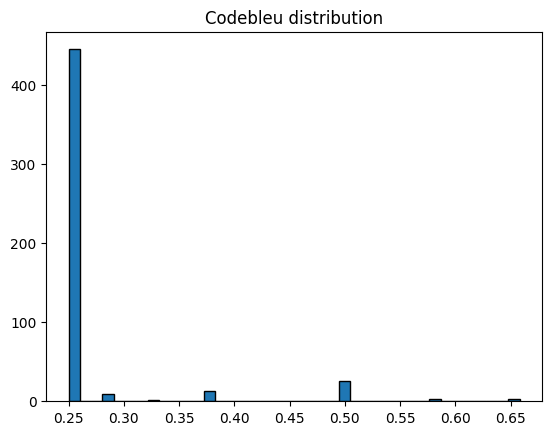

In [37]:
hist_codebleu(metrics)

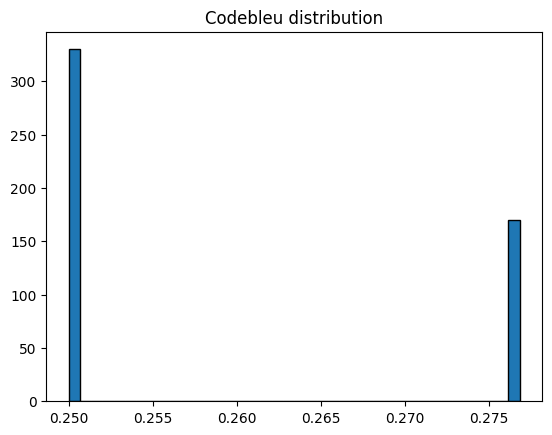

In [38]:
hist_codebleu(metrics_ft)